In [273]:
from datetime import datetime
import os
import matplotlib
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')

from scipy import sparse
from scipy.sparse import csc_matrix
from sklearn.decomposition import TruncatedSVD


## Analyse Dataset


### Movie lens Dataset
https://grouplens.org/datasets/movielens/


In [274]:
movies_df=pd.read_csv("movies.csv",usecols=['movieId','title'])
movies_df = movies_df.dropna()
movies_df.head(2)

,movieId,title
0,1,Toy Story (1995)
1,2,Jumanji (1995)


In [275]:
links_df=pd.read_csv("links.csv")
links_df = links_df.dropna()
links_df=links_df[['movieId','tmdbId']]


In [276]:
rating_df=pd.read_csv("ratings.csv")
rating_df = rating_df.dropna()
rating_df=rating_df[['userId','movieId','rating','timestamp']]
rating_df = pd.merge(rating_df,movies_df,on='movieId')
rating_df.head(2)

,userId,movieId,rating,timestamp,title
0,1,1,4.0,964982703,Toy Story (1995)
1,5,1,4.0,847434962,Toy Story (1995)


## Final dataset

In [277]:
movies_df.head(1)

,movieId,title
0,1,Toy Story (1995)


In [278]:
rating_df.head(1)

,userId,movieId,rating,timestamp,title
0,1,1,4.0,964982703,Toy Story (1995)


### Get  Train and test dataset

- One approach can be First set an threshhold (say 100) based on rating count and filter out users who gave less rating than our threshold.
- Now  consider total 30  movies recently watched by all the users as Test dataset.We train our model based on the other datset.This is possible as we already know that most of the user rated  atleast 20 movies.
- Our task is to recommend 5 movies and then check with test dataset to see if they have rated any of the movies we recommended

### Analyse rating dataset 
- First we will remove all movies that got less rating
- Check distribution of rating provided by various users

<AxesSubplot:ylabel='Frequency'>

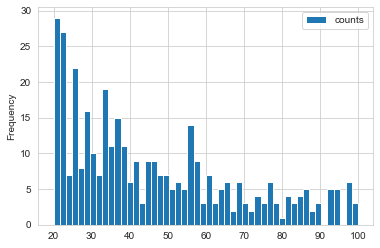

In [279]:
rating_counts_df=rating_df.groupby(['userId'])['rating'].size().reset_index(name='counts')
rating_counts_df_query=pd.DataFrame(rating_counts_df['counts'])
rating_counts_df_query=rating_counts_df_query.query('counts<= 100')
rating_counts_df_query.plot.hist(bins=50)



In [280]:
rating_counts_df.sort_values('counts')
rating_counts_df=rating_counts_df.query('counts >= 100')
rating_counts_df.head(5)

,userId,counts
0,1,232
3,4,216
5,6,314
6,7,152
9,10,140


In [281]:
rating_df.shape

(100836, 5)

In [282]:
rating_df=rating_df[rating_df.loc[:,'userId'].isin(rating_counts_df['userId'])]
rating_df.shape

(84313, 5)

#### Observation:All  users give more than 20 rating in total

In [283]:
combine_rating = rating_df.dropna(axis = 0, subset = ['title'])
movie_ratingCount = (combine_rating.
     groupby(by = ['title'])['rating'].
     count().
     reset_index().
     rename(columns = {'rating': 'totalRatingCount'})
     [['title', 'totalRatingCount']]
    )
movie_ratingCount.head()

,title,totalRatingCount
0,'71 (2014),1
1,'Hellboy': The Seeds of Creation (2004),1
2,'Round Midnight (1986),2
3,'Til There Was You (1997),1
4,'Tis the Season for Love (2015),1


In [284]:
rating_df_totalRatingCount = combine_rating.merge(movie_ratingCount, left_on = 'title', right_on = 'title', how = 'left')
rating_df_totalRatingCount.head()

,userId,movieId,rating,timestamp,title,totalRatingCount
0,1,1,4.0,964982703,Toy Story (1995),137
1,7,1,4.5,1106635946,Toy Story (1995),137
2,15,1,2.5,1510577970,Toy Story (1995),137
3,17,1,4.5,1305696483,Toy Story (1995),137
4,18,1,3.5,1455209816,Toy Story (1995),137


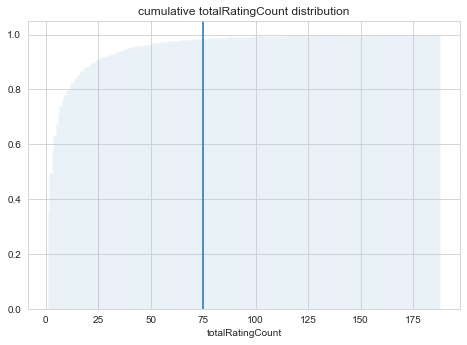

In [285]:

import scipy.stats as st

data = movie_ratingCount.loc[:, 'totalRatingCount'].values


fig = plt.figure()
ax = fig.add_axes([0,0,1,1])

ax.hist(
    data,
    alpha=0.1,
    bins=300,
    density=True,
    cumulative=True
)
ax.axvline(x=75)

plt.xlabel('totalRatingCount')
plt.title('cumulative totalRatingCount distribution')
plt.show()

In [286]:

rating_popular_df= rating_df_totalRatingCount.query('totalRatingCount >= 100')
rating_popular_df.head()

,userId,movieId,rating,timestamp,title,totalRatingCount
0,1,1,4.0,964982703,Toy Story (1995),137
1,7,1,4.5,1106635946,Toy Story (1995),137
2,15,1,2.5,1510577970,Toy Story (1995),137
3,17,1,4.5,1305696483,Toy Story (1995),137
4,18,1,3.5,1455209816,Toy Story (1995),137


### Split train and test dataset

In [287]:
rating_popular_df

,userId,movieId,rating,timestamp,title,totalRatingCount
0,1,1,4.0,964982703,Toy Story (1995),137
1,7,1,4.5,1106635946,Toy Story (1995),137
2,15,1,2.5,1510577970,Toy Story (1995),137
3,17,1,4.5,1305696483,Toy Story (1995),137
4,18,1,3.5,1455209816,Toy Story (1995),137
...,...,...,...,...,...,...
38982,600,1036,3.0,1237859371,Die Hard (1988),110
38983,603,1036,4.0,953927732,Die Hard (1988),110
38984,607,1036,5.0,963078932,Die Hard (1988),110
38985,608,1036,3.0,1117415358,Die Hard (1988),110


In [288]:
#rating_popular_df.sort_values(by=['timestamp']).groupby('userId').head(5)
x=rating_popular_df
rating_tmp=rating_popular_df.groupby('userId')['timestamp'].rank(ascending=False)
x['ranks']=rating_tmp
x.sort_values(by=['userId','ranks'])
rating_popular_df=x.query('ranks > 30')
test_df=x.query('ranks <= 30')
rating_popular_df

C:\Users\cseka\AppData\Roaming\Python\Python36\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


,userId,movieId,rating,timestamp,title,totalRatingCount,ranks
6,21,1,3.5,1407618878,Toy Story (1995),137,36.0
14,57,1,5.0,965796031,Toy Story (1995),137,46.0
15,63,1,5.0,1443199669,Toy Story (1995),137,53.0
16,64,1,4.0,1161520134,Toy Story (1995),137,35.0
18,68,1,2.5,1158531426,Toy Story (1995),137,36.0
...,...,...,...,...,...,...,...
38972,561,1036,4.5,1491090835,Die Hard (1988),110,46.0
38974,573,1036,5.0,1186589677,Die Hard (1988),110,42.0
38976,580,1036,4.0,1167673418,Die Hard (1988),110,59.0
38980,597,1036,4.0,940362197,Die Hard (1988),110,34.0


## Applying Collaborative Filtering:
From the dataset we have in hand, we can see we have enough data for various items as well as how users rate the items.
So We can apply any standard collaborative filtering  techniques that can predict the interaction between user and item.
This help to provide recommendsations   the past behaviour of users.

#### Filter out unnecessary rows before training the model
- We can consider multiple parameters like total responses received by an item from all users.Like In this dataset we can consider total rating count and set some threshold to filterout movies got less response.

## Transform the values of the dataframe into a scipy sparse matrix.


###  Step1: Convert dataframe of movie features to  sparse matrix

In [289]:
from scipy.sparse import csr_matrix
# pivot ratings into movie features
movie_features_df = rating_popular_df.pivot_table(
    index='title',
    columns='userId',
    values='rating'
).fillna(0)
# convert dataframe of movie features to scipy sparse matrix

In [290]:
movie_features_df

userId,1,7,15,17,18,19,21,28,42,45,...,593,596,597,599,600,603,606,607,608,610
title,,,,,,,,,,,,,,,,,,,,,
Aladdin (1992),0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,5.0,...,0.0,0.0,0.0,0.0,3.5,0.0,0.0,0.0,3.0,0.0
Alien (1979),0.0,0.0,0.0,0.0,4.0,4.0,0.0,3.5,0.0,0.0,...,0.0,0.0,0.0,0.0,2.5,5.0,0.0,0.0,0.0,0.0
Aliens (1986),0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0
American Beauty (1999),5.0,0.0,4.0,0.0,0.0,4.0,0.0,4.0,0.0,0.0,...,0.0,0.0,5.0,0.0,4.5,5.0,4.5,0.0,5.0,0.0
Apollo 13 (1995),0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,2.5,2.0,0.0,0.0,0.0,2.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
True Lies (1994),0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,...,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,3.0,5.0
"Truman Show, The (1998)",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,4.0,3.5,0.0,0.0,0.0,4.5,5.0
Twelve Monkeys (a.k.a. 12 Monkeys) (1995),0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.5,0.0,0.0,...,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,3.5,4.5


In [291]:
movie_features_df.columns

Int64Index([  1,   7,  15,  17,  18,  19,  21,  28,  42,  45,
            ...
            593, 596, 597, 599, 600, 603, 606, 607, 608, 610],
           dtype='int64', name='userId', length=126)

### Step3: Train our model

In [292]:
from scipy.sparse import csr_matrix

movie_features_df_matrix = csr_matrix(movie_features_df.values)

from sklearn.neighbors import NearestNeighbors


model = NearestNeighbors(metric = 'cosine', algorithm = 'brute')
model.fit(movie_features_df_matrix)

NearestNeighbors(algorithm='brute', metric='cosine')

In [293]:
model.fit(movie_features_df_matrix)


NearestNeighbors(algorithm='brute', metric='cosine')

### Step4:  Generate recommendations

### Generate movie recommendations for Toy Story (1995)

In [294]:
query_index = movie_features_df.index.get_loc('Toy Story (1995)')
#print(query_index)
distances, indices = model.kneighbors(movie_features_df.iloc[query_index,:].values.reshape(1, -1), n_neighbors = 15)

In [295]:
for i in range(0, len(distances.flatten())):
    if i == 0:
        print('Recommendations for {0}:\n'.format(movie_features_df.index[query_index]))
    else:
        print('{0}: {1}'.format(i, movie_features_df.index[indices.flatten()[i]]))

Recommendations for Toy Story (1995):

1: Jurassic Park (1993)
2: Aladdin (1992)
3: True Lies (1994)
4: Star Wars: Episode VI - Return of the Jedi (1983)
5: Back to the Future (1985)
6: Forrest Gump (1994)
7: Star Wars: Episode V - The Empire Strikes Back (1980)
8: Mask, The (1994)
9: Star Wars: Episode IV - A New Hope (1977)
10: Mission: Impossible (1996)
11: Independence Day (a.k.a. ID4) (1996)
12: Matrix, The (1999)
13: Men in Black (a.k.a. MIB) (1997)
14: Raiders of the Lost Ark (Indiana Jones and the Raiders of the Lost Ark) (1981)


### Let's apply this model for an user
- First we select top 5 recently rated item by user

In [310]:
query_df=rating_popular_df[rating_popular_df['userId']==21]
query_df=query_df.sort_values(by = ['timestamp', 'rating'], ascending = [False, False], na_position = 'first')
query_df=query_df.head(5)
query_df

,userId,movieId,rating,timestamp,title,totalRatingCount,ranks
4836,21,1198,4.0,1417378082,Raiders of the Lost Ark (Indiana Jones and the...,138,31.0
1046,21,260,4.5,1417378080,Star Wars: Episode IV - A New Hope (1977),167,32.0
5168,21,1210,4.5,1417378078,Star Wars: Episode VI - Return of the Jedi (1983),146,33.0
9476,21,2571,4.0,1412967844,"Matrix, The (1999)",174,34.0
15112,21,588,4.0,1407618992,Aladdin (1992),114,35.0


In [412]:
from collections import Counter
indicesList=[]


for i in query_df['title']:
    query_index = movie_features_df.index.get_loc(i)
    distances, indices = model.kneighbors(movie_features_df.iloc[query_index,:].values.reshape(1, -1), n_neighbors = 50)
    indicesList.append(indices.tolist())
indicesList= [val for sublist in indicesList for val in sublist]
movies=[]
for i in indicesList:
        movies.append(movie_features_df.index[i])
movies = [m for sublist in movies for m in  sublist]
movies=Counter(movies)


In [420]:
movies_already_watched=rating_popular_df[rating_popular_df['userId']==21]['title']
movies_already_watched=list(movies_already_watched.values)


In [422]:

recommendation=[item for index, item in enumerate(movies) if item not in movies_already_watched][:10]

recommendation

['Terminator 2: Judgment Day (1991)',
 'Braveheart (1995)',
 'Die Hard (1988)',
 'Indiana Jones and the Last Crusade (1989)',
 'Terminator, The (1984)',
 'Princess Bride, The (1987)',
 'Incredibles, The (2004)',
 'Alien (1979)',
 'Saving Private Ryan (1998)',
 'Seven (a.k.a. Se7en) (1995)']

### Verify in testset

In [346]:
lists_df=test_df[test_df['userId']==21]

In [427]:
print("Successful hit : %3d, out of : %2d" % (len(lists_df[lists_df['title'].isin(recommendation)]), len(recommendation)))


Successful hit :   6, out of : 10
